In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

#drive.mount("/content/gdrive", force_remount=True)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import os, csv
from tqdm import tqdm, trange

In [0]:
#first, identify the right file path

!ls "/content/gdrive/My Drive/humor_style_transfer/reddit_jokes/joke-dataset/style_trans_preprocessing"

bert_classifier_training  jokes.test.1
joke_captions		  jokes.train.0
jokes.dev.0		  jokes.train.1
jokes.dev.1		  processed_files_with_bert_with_best_head
jokes.test.0


In [0]:
'''
todo before running the below:
  * the reddit data needs to be formatted like "imagecaption_train_1" data.

  (1) - I suggest combining the title and joke content into one sentence
  - filter out the ones that are too long
  - maybe just use a subset of the jokes?
    - 0/1: jokes that are badly ranked vs. jokes that are well ranked?
  
  - also, I need to change multi-line to single-line jokes.
  
'''
import json
import csv

reddit_jokes_path = "/content/gdrive/My Drive/humor_style_transfer/reddit_jokes/joke-dataset"
#open the reddit jokes, combine title and content.
with open(reddit_jokes_path + "/reddit_jokes.json") as jokes_json:
  jokes_js_obj = json.loads(jokes_json.read())
  print(jokes_js_obj[0])

ctr = 0
with open(reddit_jokes_path + "/style_trans_preprocessing/joke_captions_1_mod", 'w') as csvfile:
  jokewriter = csv.writer(csvfile, delimiter = '\t')

  #let's combine the title and body of the jokes.
  for joke in jokes_js_obj:
    #ctr += 1
    #if ctr >= 100:
    #  break

    #print(joke['title'])
    t = joke['title'].strip()
    f = [t]
    if t[-1] not in ['?', '.', '!']:
      f.append('.')
    f.append(' ')

    f.append(joke['body'].strip())
    joke_full_text = ''.join(f)
    joke_full_text = joke_full_text.replace('\n', ' ')
    joke_class = 0 if joke['score'] <= 3 else 1

    #write out the jokes to the file.
    jokewriter.writerow([joke_full_text, str(joke_class)])


{'body': 'Now I have to say "Leroy can you please paint the fence?"', 'id': '5tz52q', 'score': 1, 'title': 'I hate how you cant even say black paint anymore'}


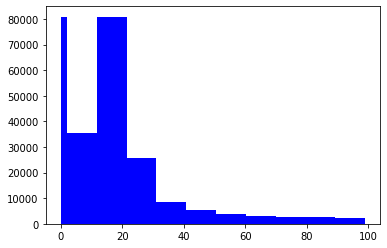

In [0]:
#exploration: 
# 1. let's see how the joke upvotes are distributed.
# 2. let's see how the joke lengths are distributed.

#1. check the joke upvotes.
import matplotlib.pyplot as plt

upvotes = []
for joke in jokes_js_obj:
  upvotes.append(joke['score'])

#count: ~200k
#now, plot the upvotes.
x = [u for u in upvotes if u < 20]
num_bins = 10
n, bins, patches = plt.hist(x, num_bins, facecolor='blue')
#plt.show()

### *3* seems to be a good division point between popular and unpopular jokes. (About 95k jokes have less than 3 upvotes.)

#2. check out the joke lengths
lens = []
for joke in jokes_js_obj:
  lens.append( len(joke['title'].split(' ')) + len(joke['body'].split(' ')) )

x = [l for l in lens if l < 100]
num_bins = 10
n, bins, patches = plt.hist(x, num_bins, facecolor='blue')
plt.show()

### *30* tokens seems to be a good place to cut off joke lengths? About 170k jokes are shorter than 20 tokens. But I think a lot of the best ones are 20-30

In [0]:
## next, we should split the training data into training, test, and dev sets.

#how is it split in the other files?
#! wc -l '/content/gdrive/My Drive/humor_style_transfer/style-transfer-data/Sentiment-and-Style-Transfer/data/yelp/bert_classifier_training/dev.csv'

#dev set: 4k lines.
#test set: 1k lines.
#train set: 400k lines.

ntest = 1000
ndev = 4000
ntrain = 200000
ctr = 0
with open(reddit_jokes_path + "/style_trans_preprocessing/joke_captions", 'r') as csvfile:
  jokereader = csv.reader(csvfile, delimiter = '\t', quotechar = '"', quoting=csv.QUOTE_MINIMAL)
  #test
  with open(reddit_jokes_path + "/style_trans_preprocessing/bert_classifier_training/test.csv", 'w') as testfile:
    testwriter = csv.writer(testfile, delimiter = '\t', quotechar = '"', quoting=csv.QUOTE_MINIMAL)
    for line in jokereader:
      ctr += 1
      if ctr >= ntest:
        break
      #print(line)
      testwriter.writerow(line)

  #dev
  ctr = 0
  with open(reddit_jokes_path + "/style_trans_preprocessing/bert_classifier_training/dev.csv", 'w') as devfile:
    devwriter = csv.writer(devfile, delimiter = '\t', quotechar = '"', quoting=csv.QUOTE_MINIMAL)
    for line in jokereader:
      ctr += 1
      if ctr >= ndev:
        break
      #print(line)
      devwriter.writerow(line)
  
  print("finished dev and test sets!")

  #train
  with open(reddit_jokes_path + "/style_trans_preprocessing/bert_classifier_training/train.csv", 'w') as trainfile:
    trainwriter = csv.writer(trainfile, delimiter = '\t', quotechar = '"', quoting=csv.QUOTE_MINIMAL)
    for line in jokereader:
      ctr += 1
      if ctr >= ntrain:
        break
      #print(line)
      trainwriter.writerow(line)

finished dev and test sets!


In [0]:
#[to fix:] let's kill the newlines and quotes...
### repeat the above, but relace "dev" with "train" and "test" (modularize the above...)
import csv
def split_binary_file(inpath, outpath0, outpath1, maxlines):
  out1_lines = []
  out0_lines = []
  ctr = 0
  with open(inpath) as infile:
    jokereader = csv.reader(infile, delimiter = '\t', quotechar = '"', quoting=csv.QUOTE_MINIMAL)
    for line in jokereader:
      ctr += 1
      if ctr >= maxlines:
        break
      lmod = line[0].replace('\n', ' ')
      if line[1] == '1':
        out1_lines.append(lmod)
      else:
        out0_lines.append(lmod)

  print(out1_lines[:10])
  print(out0_lines[:10])

  #populate the out1 file
  with open(outpath1, 'w') as class1file:
    #jokewriter = csv.writer(class1file, delimiter = '\t', quotechar = '"', quoting=csv.QUOTE_MINIMAL)
    for line in out1_lines:
      class1file.write(line+'\n')

  #populate the out0 file.
  with open(outpath0, 'w') as class0file:
    #jokewriter = csv.writer(class0file, delimiter = '\t', quotechar = '"', quoting=csv.QUOTE_MINIMAL)
    for line in out0_lines:
      class0file.write(line+'\n')

In [0]:
reddit_jokes_path = "/content/gdrive/My Drive/humor_style_transfer/reddit_jokes/joke-dataset/"

'''#use the above function for test data
testin = reddit_jokes_path + 'style_trans_preprocessing/bert_classifier_training/test.csv'
testout0 = reddit_jokes_path + 'style_trans_preprocessing/jokes.test.0'
testout1 = reddit_jokes_path + 'style_trans_preprocessing/jokes.test.1'
split_binary_file(testin, testout0, testout1, 100000)'''

#use the above function for train data
testin = reddit_jokes_path + 'style_trans_preprocessing/bert_classifier_training/dev.csv'
testout0 = reddit_jokes_path + 'style_trans_preprocessing/jokes.dev.0'
testout1 = reddit_jokes_path + 'style_trans_preprocessing/jokes.dev.1'
split_binary_file(testin, testout0, testout1, 1000000)

['How do you get a jewish girls number? You roll up her sleeve.', 'What is the most common job among spiders? Web designer.', "Loyalty is very important for my wife... My girlfriend doesn't care.   Funny how different sisters can be.", 'What do you get when there is a death at a funeral? A rehearsal.', "A New Yorker went for a checkup.. Doctor: We're sorry, you have Hepatitis B.  New Yorker: Damn B, what kind of hepatitis?\ufeff", 'I applied for a job at a blacksmiths. He asked if ive ever shoed a horse before.   I said no but i once told a donkey to fuck off', 'What do you call a pessimistic Mexican doing math? Negative Juan.', 'Surprise bj. I woke up to a surprise blowjob today.  I should really start sleeping with my mouth closed', "What do you call a cuddle with only one person? A cddle, because u weren't there", "Rick Astley will let you borrow any movie from his collection except for one. He's never gonna give you Up."]
['What do people smoke in concentration camps? MariJEWana', 

In [0]:
### next step, process the flickr data - get it ready for input into the "DRG" pipeline.

# a potentially interesting future step: try to generate a joke out of all 5 images, see which one is the best?
flickr_path = "/content/gdrive/My Drive/humor_style_transfer/flickr8k/"
new_f_name = "flickr_drg_input_v1.txt"
img_unq_caps = []
ctr = 0
maxlen = 40
#line_limit = 100000
with open(flickr_path + 'Flickr8k.token.txt') as f:
  with open(flickr_path + new_f_name, 'w') as fout:
    prevtag=None
    for line in f:
      #ctr += 1
      #if ctr >= line_limit:
      #  break
      linearr = line.split(' ')
      if len(linearr) > maxlen:
        continue
      tag = linearr[0]
      #add special tags for drg processing
      linearr[0] = '<POS> <CON_START>'
      linearr[-1] = '. <START>\n'
      sentence = ' '.join(linearr)
      #optionally, do something with captions for the same img.
      #if tag == prevtag:
      #  continue
      #else:
      #  prevtag = tag
      fout.write(sentence)

In [0]:
!wc -l '/content/gdrive/My Drive/humor_style_transfer/flickr8k/flickr_drg_input_v1.txt'

40460 /content/gdrive/My Drive/humor_style_transfer/flickr8k/flickr_drg_input_v1.txt
